In [11]:
from lib.csv_scores import *

## Lets read in the data

In [12]:
UCLA_csv = "../misc/pairwise_annot.csv"
luca_csv = "../misc/pairwise_annot_luca_ecb.csv"

In [13]:
df_UCLA_raw = pd.read_csv(UCLA_csv, index_col=0)
df_luca_raw = pd.read_csv(luca_csv, index_col=0)

## First, lets process image raw scores

In [14]:
UCLA_csv_out = "output/UCLA_raw_scores.csv"
luca_csv_out = "output/luca_1000_raw_scores.csv"
if not os.path.exists(UCLA_csv_out):
    GenerateChoixScores(df_UCLA_raw, UCLA_csv_out)
    
if not os.path.exists(luca_csv_out):
    GenerateChoixScores(df_luca_raw, luca_csv_out)

In [15]:
# read scores and mini max them
df_UCLA = MinMax(ReadScoresFromCsv(UCLA_csv_out), "violence")
df_luca = MinMax(ReadScoresFromCsv(luca_csv_out), "violence")

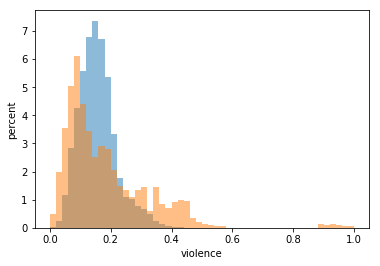

In [16]:
# check distribution
plt.hist(df_UCLA['violence'], 50, label = "UCLA", alpha=0.5, density = 1)
plt.hist(df_luca['violence'], 50, label = "luca", alpha=0.5, density = 1)
plt.xlabel('violence')
plt.ylabel('percent')
plt.show()

Below here we use the Kolmogorov–Smirnov to evaluate if both distributions come from the same population. The interpretation of the p value according to https://www.graphpad.com/guides/prism/7/statistics/interpreting_results_kolmogorov-smirnov_test.htm?toc=0&printWindow is as follows:

"If the two samples were randomly sampled from identical populations, what is the probability that the two cumulative frequency distributions would be as far apart as observed?"

In [17]:
print(stats.ks_2samp(df_UCLA['violence'], df_luca['violence']).pvalue)

7.228869847691746e-27


Uuuh, it does not look like they come from the same distribution

## Now, lets do the same considering we clip it

In [8]:
df_UCLA_clipped = MinMax(ClipValues(df_UCLA, 0.43), 'violence')
df_luca_clipped = MinMax(ClipValues(df_luca, 0.62), 'violence')

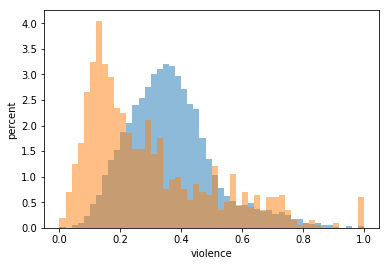

In [9]:
# check distribution
plt.hist(df_UCLA_clipped['violence'], 50, label = "UCLA", alpha=0.5, density = 1)
plt.hist(df_luca_clipped['violence'], 50, label = "luca", alpha=0.5, density = 1)
plt.xlabel('violence')
plt.ylabel('percent')
plt.show()

In [10]:
print(stats.ks_2samp(df_UCLA_clipped['violence'], df_luca_clipped['violence']).pvalue)

4.4701117925180545e-98


Uhhhh x2, even worst. Definitely not the same distribution

## All right, now lets have a look at the effect of clipping

The aim here is to investigate if we loose precision by clipping images. In order to do that, we visually inspect the differences between the images with labels bigger than the cut point, and images slightly below the cut point

### First lets look at UCLA

In [15]:
UCLA_very_violent = df_UCLA[df_UCLA['violence'] > 0.43]
UCLA_cut_point = df_UCLA[(df_UCLA['violence'] <= 0.43) & (df_UCLA['violence'] >= 0.38) ]

In [19]:
images_dir = "../../images"
images_to_print = 5

### Ivestigating mages close to 1

In [20]:
img_paths = UCLA_very_violent['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../images/test-03961.jpg'

### Ivestigating mages close to the cut point

In [18]:
img_paths = UCLA_cut_point['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../images/train-04265.jpg'

Images close to 1 do not seem to differ much from the images that are close to our clipping point. This indicates that we probably should treat them as outliners in terms of scores. In other words, pulling their scores closer to each other should not cause us a lost in precision in the range of violence

### Now lets look at Luca data

In [62]:
luca_very_violent = df_luca[df_luca['violence'] > 0.6]
luca_cut_point = df_luca[(df_luca['violence'] <= 0.6) & (df_luca['violence'] >= 0.5) ]

### Ivestigating mages close to 1

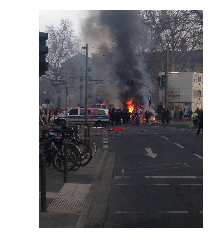

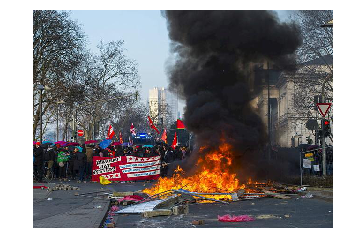

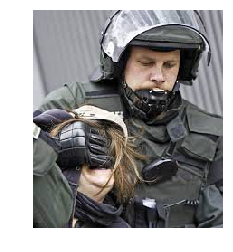

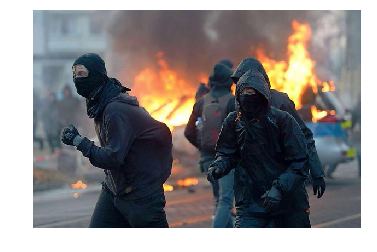

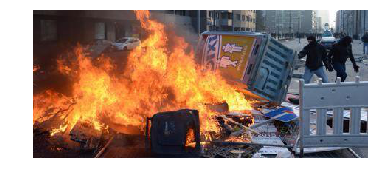

In [60]:
img_paths = luca_very_violent['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Ivestigating mages close to the cut point

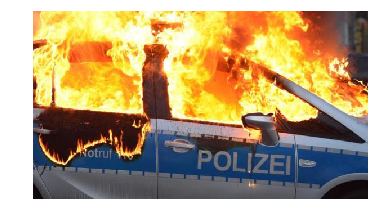

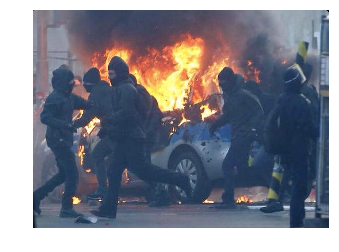

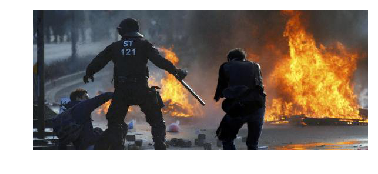

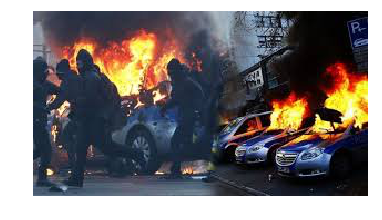

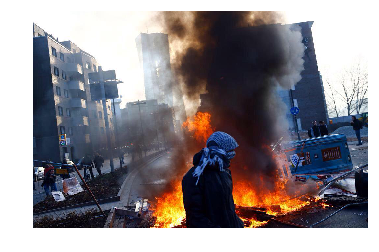

In [63]:
img_paths = luca_cut_point['fname'].tolist()

for img_path in img_paths[:images_to_print]:
    path = os.path.join(images_dir, img_path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

It seems that the statement above also holds for Luca's dataset